I was golfing the other day and was having a bad day. I was thinking about my experience golfing with different groups and that got me thinking about "feeding off" the play of my fellow group members. I decided it would be fun to investigate whether the so called "feed-off effect" is real. I was given access to the data from the PGA Tour through the ShotLink Intelligence Program so I decided to use this data in an analysis of the pro game (data from my personal game is lacking).

This feed-off effect is something that is often mentioned on telecasts and in conversations about the game and is often supported with anecdotes. This analysis intends to answer the basic question of whether there is statistically significant evidence of this effect existing. I will do this by seeing if the within group variation or spread is significantly less substantial than the between group variation during a given round. If the effect does exists, I will go on to investigate other questions that might be interesting like - does it exists especially at certain tournaments? On certain courses? For certain players? During certain times? Under certain circumstances? Golf geeks rejoice!

### Munging
#### tl;dr did a bunch of quality verification, matched starting hole from another table, ended up with a dataframe with a tuple that can be used to identify each group

In [1]:
## the standard imports
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## reading in round level data
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    round_data = pd.concat([pd.read_csv('../data/rawdata/%dr.txt'
                            % year, sep=';') 
                            for year in range(2003,2017)])

In [3]:
## taking a look at the dimensions
round_data.shape

(261539, 179)

In [4]:
## making the columns easier to work with
round_data.columns = [col.replace(' ','_') 
                      for col in round_data.columns]

In [5]:
## look at the first 3 rows
round_data.head(3)

,Tour,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Team_ID,Team_Number,Player_Number,Player_Name,Round_Number,Event_Name,Course_Name,Course_Par,Course_Yardage,Tee_Time,Round_Score,End_of_Round_Finish_Pos._(numeric),End_of_Round_Finish_Pos._(text),_End_of_Event_Pos._(numeric),End_of_Event_Pos._(text),In_Playoff,Eagles,Eagles(Rank),Birdies,Birdies_(Rank),Pars,Bogeys,Bogeys_(Rank),Doubles,Others,Total_Holes_Over_Par,_Bogey_Avoidance_Rank,Longest_Drive,Longest_Drives(Rank),Driving_Distance(Total_Distance),Driving_Distance(Total_Drives),Driving_Distance(Rank),Driving_Dist._-_All_Drives(Tot._Dist.),Driving_Dist._-_All_Drives(#_of_Drives),Driving_Dist._-_All_Drives(Rank),Drives_Over_300_Yards_(#_of_Drives),Driving_Acc._%(Fairways_Hit),Driving_Acc._%(Possible_Fairways),Driving_Accuracy_Rank,Left_Rough_Tendency(Total_Left_Rough),Right_Rough_Tendency(Total_Right_Rough),App._50-75_yds(ft),App._50-75_yds(attempts),App._75-100_yds(ft),App._75-100_yds(attempts),App._100-125_yds(ft),App._100-125_yds(attempts),Approaches_50-125_Yards(ft),Approaches_50-125_Yards(attempts),Approaches_125-150_Yards(ft),Approaches_125-150_Yards(attempts),Approaches_150-175_Yards(ft),Approaches_150-175_Yards(attempts),Approaches_175-200_Yards(ft),Approaches___175-200_Yards(attempts),Approaches_>200_Yards(ft),Approaches_>200_Yards(attempts),App._50-75_yds(ft)_-_Rough,App._50-75_yds(attempts)_-_Rough,App._75-100_yds(ft)_-_Rough,App._75-100_yds(attempts)_-_Rough,App._100-125_yds(ft)_-_Rough,App._100-125_yds(attempts)_-_Rough,Approaches_50-125_Yards(ft)_-_Rough,Approaches_50-125_Yards(attempts)_-_Rough,Approaches_125-150_Yards(ft)_-_Rough,Approaches_125-150_Yards(attempts)_-_Rough,Approaches_150-175_Yards(ft)_-_Rough,Approaches_150-175_Yards(attempts)_-_Rough,Approaches_175-200_Yards(ft)_-_Rough,Approaches_175-200_Yards(attempts)_-_Rough,Approaches_>200_Yards(ft)_-_Rough,Approaches_>200_Yards(attempts)_-_Rough,Total_Holes_Played,Total_Greens_in_Regulation,GIR_Rank,Total_Distance(ft)_Prox_to_Hole,_#_of_Attempts_Prox_to_Hole,Proximity_to_Hole_(Rank),Fairway_Prox(attempts),Fairway_Prox(distance_in_ft),Fairway_Prox_(Rank),Rough_Prox(attempts),Rough_Prox(distance_in_ft),Rough_Prox_(Rank),Left_Rough_Prox(attempts),Left_Rough_Prox(distance_in_ft),Right_Rough_Prox(attempts),Right_Rough_Prox(distance_in_ft),Going_for_Green(attempts),Going_for_Green(non-attempts),Going_for_the_Green(successes),Scrambling_Par_or_Better,Scrambling_Missed_GIR,Scrambling_(Rank),Scrambling_Proximity_(Total_Distance),Scrambling_Proximity_(#_of_shots),Scrambling_Proximity_(rank),Scrambling_from_the_Rough(successes),Scrambling_from_the_Rough(attempts),Scrambling_from_the_Fringe(successes),Scrambling_from_the_Fringe(attempts),Scrambling_>30_Yards(successes),_Scrambling_>30_Yards(attempts),Scrambling___20-30_Yards(successes),_Scrambling_20-30_Yards(attempts),Scrambling_10-20_Yards(successes),_Scrambling_10-20_Yards(attempts),Scrambling_<_10_Yards(successes),_Scrambling_<_10_Yards(attempts),Sand_Save_%(#_Saves),Sand_Save_%(#_Bunkers),Sand_Save_(Rank),Prox_to_Hole_from_Sand(Total_Distance),_Prox_to_Hole_from_Sand(#_of_Shots),Total_Hole_Outs,Longest_Hole_Out(yards),Overall_Putting_Avg(#_of_Putts),_Putting_Avg(GIR_Putts),One-Putt_%(#_of_One_Putts),3-Putt_Avoid(Total_3_Putts),Approach_Putt_Performance(attempts),Approach_Putt_Performance(ft)),Avg_Distance_of_Putts_Made(Total_Distance_of_Putts),Putting___3'(attempts),Putting___3'(putts_made),Putting___4'(attempts),Putting_4'(putts_made),Putting_5'(attempts),Putting_5'(putts_made),Putting_6'(attempts),Putting_6'(putts_made),Putting_7'(attempts),Putting_7'(putts_made),Putting_8'(attempts),Putting_8'(putts_made),Putting___9'(attempts),Putting_9'(putts_made),Putting_10'(attempts),Putting_10'(putts_made),Putting_Inside_5'_(putts_made),Putting_Inside_5'_(attempts),Putting_Inside_5_Feet_(Rank),Putting_5'_-_10'_(putts_made),Putting_5'_-_10'_(attempts),Putting_5'_-_10'_(Rank),Putting_4'-8'(attempts),Putting_4'-8'(putts_made),Putting_4'_-_8'_(Rank),Puttin

Alright, that is a lot of columns! We probably only need a handful of them so I will choose some of them and delete the rest.

In [6]:
round_cols = ['Tournament_Year','Permanent_Tournament_#','Event_Name',
              'Course_#','Course_Name','Player_Number','Player_Name',
              'Round_Number','Tee_Time','Round_Score',
              'End_of_Round_Finish_Pos._(text)']
for col in round_data.columns:
    if col in round_cols:
        continue
    del round_data[col]

In [7]:
## new dimensions
round_data.shape

(261539, 11)

In [8]:
## first three rows
round_data.head(3)

,Tournament_Year,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Event_Name,Course_Name,Tee_Time,Round_Score,End_of_Round_Finish_Pos._(text)
0,2003,16,656,1320,"Estes, Bob",1,Mercedes Championships,Plantation Course at Kapalua,11:50,66,T6
1,2003,16,656,1361,"Forsman, Dan",1,Mercedes Championships,Plantation Course at Kapalua,11:00,69,T14
2,2003,16,656,1761,"Mattiace, Len",1,Mercedes Championships,Plantation Course at Kapalua,13:00,75,36


Ok now, there is a slight problem. We have the tee times for each player but to know which groups the players were in, we actually need to know what hole they started on as well. I will demonstrate this fact by doing a groupby. But first, we need to do a quality check on the *Tee_Time* field.

In [9]:
## value counts of 'earliest' tee times
round_data.Tee_Time.value_counts().sort_index().head(3)

00:00    12
05:00     5
05:10     6
Name: Tee_Time, dtype: int64

In [10]:
## value counts of 'latest' tee times
round_data.Tee_Time.value_counts().sort_index().tail(3)

21:30      6
21:40      6
99:99    273
Name: Tee_Time, dtype: int64

In [11]:
## what is with the tee times and midnight and some made up time 99:99?
print round_data[round_data['Tee_Time']=='00:00']\
[['Tournament_Year','Event_Name']]\
.groupby(['Tournament_Year','Event_Name']).size()

print round_data[round_data['Tee_Time']=='99:99']\
[['Tournament_Year','Event_Name']]\
.groupby(['Tournament_Year','Event_Name']).size()

Tournament_Year  Event_Name        
2003             Masters Tournament    10
2006             The INTERNATIONAL      2
dtype: int64
Tournament_Year  Event_Name        
2003             Masters Tournament    273
dtype: int64


In [12]:
## it seems like there is something up with the Masters in 2003
round_data.loc[(round_data.Tournament_Year==2003)
                & (round_data.Event_Name=='Masters Tournament'),
               'Tee_Time'].value_counts()

99:99    273
00:00     10
Name: Tee_Time, dtype: int64

In [13]:
## I will drop this data since it seems to be missing the Tee Times
round_data = round_data[~((round_data.Tournament_Year==2003)
                          & (round_data.Event_Name==
                             'Masters Tournament'))]

In [14]:
## Now ready for groupby tee time
## groupby tee time, count number of players in each tee time
round_data.groupby(['Tournament_Year',
                    'Permanent_Tournament_#','Course_#',
                    'Round_Number','Tee_Time'])\
          .size().head().to_frame()\
          .rename(columns={0:'Player_Count'})

Player_Count
Tournament_Year Permanent_Tournament_# Course_# Round_Number Tee_Time              
2003            1                      101      1            07:15                6
                                                             07:24                6
                                                             07:33                6
                                                             07:42                6
                                                             07:51                6

PGA Tour groups never have more than 4 (almost positive of this fact, aside from playoffs) and rarely have more than 3. 6 players with the same tee time is actually two different groups - one going off of hole 1 and another off of hole 10. During the first two rounds of a tournament, going off both 1 and 10 - "split tees" - is common. It is much more infrequent during the last two rounds of a tournament; it typically only happens when weather becomes a concern. I'll demonstrate this by grouping by Round_Number in the previous data frame and taking the mean of the count variable.

In [15]:
## groupby Round_Number take mean of players per tee time
round_data.groupby(['Tournament_Year','Permanent_Tournament_#',
                    'Course_#','Round_Number','Tee_Time']).size()\
.reset_index().rename(columns={0:'Count'}).groupby('Round_Number',
as_index=False)['Count'].agg(['count','mean'])\
.rename(columns={'count':'number of tee times',
                 'mean':'mean players per tee time'})

,number of tee times,mean players per tee time
Round_Number,,
1,16690,5.030917
2,16439,5.008212
3,17484,2.788607
4,17172,2.639005
5,163,5.049080
6,28,2.000000
7,4,2.000000


So we see that in rounds 3 and 4 there are rarely "split tees" since the number of players per tee time is closer to the number of players we expect to see per group - 2 or 3.

The tee times in rounds 6 and 7 are for the Match Play Championship and this data is irrelevant for the investigation at hand and unusable since there is no such thing as a Round Score for match play. So I will drop this data now.

In [16]:
## checking out what events have data for round 6 or 7
round_data.loc[round_data.Round_Number>5,
               ['Event_Name','Permanent_Tournament_#']]\
.groupby(['Event_Name','Permanent_Tournament_#'])\
.size().to_frame().rename(columns={0:'Round_Count'})

,,Round_Count
Event_Name,Permanent_Tournament_#,
World Golf Championships-Accenture Match Play Championship,470,48
World Golf Championships-Cadillac Match Play,470,8
World Golf Championships-Dell Match Play,470,8


In [17]:
## drop this data
round_data = round_data.loc[round_data['Permanent_Tournament_#']!=470]

The problem is there is no column in this particular table that has the information of what hole the player started on for the round. Without this information, it is impossible to determine the groups. We will need to find this information in the hole-level table. I will import this data and we will have a look.

In [18]:
## reading in hole level data and making columns easier to work with
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    hole_data = pd.concat([pd.read_csv('../data/rawdata/%dh.txt'
                           % year, sep=';') 
                           for year in range(2003,2017)])
    hole_data.columns = [col.replace(' ','_') 
                         for col in hole_data.columns]

In [19]:
## dimensions of hole-level data
hole_data.shape

(4679476, 56)

In [20]:
## first three rows of hole-level data
hole_data.head(3)

,Tour,Tournament_Year,Tournament_Schedule_#,Permanent_#,Player_#,Course_#,Player_Name,Hole_#,Round_#,Final_Round,Event_Name,Course_Name,Par,Scorecard_Yard,Actual_Yard,Score,RTP_Score,Hit_Fwy,Hit_Green,Hit_Greenside_Bunker,Sand_Save,Scrambling_Success,Putts,Driving_Distance_(rounded),Tee_Shot_Landing_Loc,Tee_Shot_Detail_Landing_Loc,Appr_Shot_Dist_to_the_Pin,Appr_Shot_Prox_to_the_Hole,Appr_Shot_Landing_Loc,Appr_Shot_Detail_Landing_Loc,Made_Putt_Distance,GFG_Hole,Went_for_it,GFG_Hit_Green,GFG_Shot_Dist_to_the_Pin,GFG_Shot_Prox_to_the_Hole,Driving_Dist_Measured_Flag,Measured_Driving_Distance,Appr_Shot_ended_on_or_ARG,Appr_Shot_Start_Loc,Appr_Shot_Detail_Starting_Loc,GFG_Shot_Start_Loc,GFG_Shot_Detail_Start_Loc,Hole_Seq_#,Scrambling_Shot_Start_Loc,Scrambling_Shot_Detail_Start_Loc,Scrambling_Shot_dist_from_Hole,Scrambling_Shot_Prox_to_Hole,Time_Hole_Finished,Putts_Gained,SG_T2G,SG_Total,OTT_Strokes_Gained,APP_Strokes_Gained,ARG_Strokes_Gained,Unnamed:_55
0,PGA TOUR,2003,10,16,1320,656,"Estes, Bob",1,1,0,Mercedes Championships,Plantation Course at Kapalua,4,473,0,4.0,0,1,1,0,0,-1,2,0,NaN,NaN,0,0,Green,NaN,0,0,-1,-1,0,0,N,0,Y,Fairway,NaN,NaN,NaN,1,NaN,NaN,0,0,11:57,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,PGA TOUR,2003,10,16,1320,656,"Estes, Bob",2,1,0,Mercedes Championships,Plantation Course at Kapalua,3,218,0,4.0,1,0,1,0,0,-1,3,0,NaN,NaN,0,0,Green,NaN,0,0,-1,-1,0,0,N,0,Y,Tee Box,NaN,NaN,NaN,2,NaN,NaN,0,0,12:05,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,PGA TOUR,2003,10,16,1320,656,"Estes, Bob",3,1,0,Mercedes Championships,Plantation Course at Kapalua,4,380,0,4.0,0,1,1,0,0,-1,2,0,NaN,NaN,0,0,Green,NaN,0,0,-1,-1,0,0,Y,268,Y,Fairway,NaN,NaN,NaN,3,NaN,NaN,0,0,12:15,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [21]:
## re-naming Tournament_# field so it is compatible with other table
hole_data = hole_data.rename(columns={'Permanent_#':'Permanent_Tournament_#'})

## selecting only the columns that we'll need, deleting rest
hole_cols = ['Tournament_Year','Permanent_Tournament_#',
             'Player_Name','Player_#','Course_#','Hole_#',
             'Round_#','Hole_Seq_#','Score']
for col in hole_data.columns:
    if col in hole_cols:
        continue
    del hole_data[col]
    
## removing match play championship
hole_data = hole_data[hole_data['Permanent_Tournament_#']!=470]

## removing the masters in 2003
hole_data = hole_data[~((hole_data.Tournament_Year==2003) &
                        (hole_data['Permanent_Tournament_#']==14))]

In [22]:
hole_data.head(3)

,Tournament_Year,Permanent_Tournament_#,Player_#,Course_#,Player_Name,Hole_#,Round_#,Score,Hole_Seq_#
0,2003,16,1320,656,"Estes, Bob",1,1,4.0,1
1,2003,16,1320,656,"Estes, Bob",2,1,4.0,2
2,2003,16,1320,656,"Estes, Bob",3,1,4.0,3


This is the information we need. If we just subset only the rows that contain the first hole played by each golfer and make a dictionary with a key being a tuple that uniquely identifies a player-round and a value being the first hole played by the golfer in the round, this will be easy to put into the round data frame. I'll do this now after verifying the quality of the Hole_Sequence field.

In [23]:
## value counts of the sequence field
hole_data['Hole_Seq_#'].value_counts().sort_index()

1     259270
2     259270
3     259270
4     259270
5     259270
6     259270
7     259270
8     259270
9     259270
10    259270
11    259270
12    259270
13    259270
14    259270
15    259270
16    259270
17    259270
18    259270
Name: Hole_Seq_#, dtype: int64

I find this data strangely perfect. Don't some players withdraw in the middle of the round? I'll continue by checking the *Score* field.

In [24]:
## value counts of score
hole_data['Score'].value_counts().sort_index()

1.0         427
2.0      134694
3.0     1150020
4.0     2258298
5.0      907817
6.0      129372
7.0       17565
8.0        2659
9.0         510
10.0         99
11.0         28
12.0          8
13.0          3
14.0          1
16.0          1
Name: Score, dtype: int64

In [25]:
## who made a 16 on a hole?
hole_data.sort_values('Score',ascending=False).head(1)

,Tournament_Year,Permanent_Tournament_#,Player_#,Course_#,Player_Name,Hole_#,Round_#,Score,Hole_Seq_#
112562,2011,41,25396,770,"Na, Kevin",9,1,16.0,9


In [26]:
## slight diversion let's check out the value counts of Round_Score
round_data.Round_Score.value_counts().sort_index()

58         1
59         3
60        19
61        78
62       310
63       815
64      2057
65      4580
66      8897
67     14545
68     21391
69     27306
70     31216
71     32027
72     29458
73     25097
74     19581
75     14491
76      9990
77      6691
78      4311
79      2650
80      1572
81       893
82       560
83       322
84       177
85       106
86        55
87        32
88        20
89        11
90         5
91         2
92         1
93         1
106        1
Name: Round_Score, dtype: int64

In [27]:
## who shot 58?
round_data.sort_values('Round_Score')\
[['Player_Name','Tournament_Year',
  'Event_Name','Round_Score']].head(1)

,Player_Name,Tournament_Year,Event_Name,Round_Score
16168,"Furyk, Jim",2016,Travelers Championship,58


In [28]:
## who shot 106??
round_data.sort_values('Round_Score',ascending=False)\
[['Player_Name','Tournament_Year',
  'Event_Name','Round_Score']].head(1)

,Player_Name,Tournament_Year,Event_Name,Round_Score
5539,"Casper, Billy",2005,Masters Tournament,106


In [29]:
## subsetting to only first hole of round, 
## dropping irrelevant fields, making dictionary
hole_data = hole_data[hole_data['Hole_Seq_#']==1]

hole_data.drop(['Player_Name','Score','Hole_Seq_#'],
               axis=1,inplace=True)

hole_data.set_index(['Tournament_Year','Permanent_Tournament_#',
                     'Player_#','Course_#','Round_#'],inplace=True)

start_hole = hole_data.squeeze().to_dict()

In [30]:
## how many rounds started on each hole?
hole_data.squeeze().value_counts().to_frame().sort_index()

,Hole_#
1,161941
9,311
10,96827
11,191


I'm not exactly sure why there are a few abnormalities with rounds starting on holes 9 and 11. I looked into it and found no evidence that these rounds started on holes 9 or 11. I will leave this for now and see if it is helpful in distinguishing between the different groups by grouping by group and counting the number of players later.

I'll now insert a new column for hole started on which will be used together with tee time to determine the groups.

In [31]:
## inserting Hole Started On field
round_data['Hole_Started_On'] = [start_hole[(year,tourn,player
                                             ,course,round_)]
                                 if (year,tourn,player,
                                     course,round_) in start_hole 
                                 else np.nan
                                 for (year,tourn,
                                      player,course,round_) in 
                                 zip(round_data.Tournament_Year,
                                 round_data['Permanent_Tournament_#'],
                                 round_data['Player_Number'],
                                 round_data['Course_#'],
                                 round_data['Round_Number'])]

In [32]:
## see how many rounds weren't found in hole data
round_data.Hole_Started_On.value_counts(dropna=False)\
.to_frame().sort_index()

,Hole_Started_On
1.0,161938
9.0,311
10.0,96826
11.0,191
NaN,6


In [33]:
## dropping the few rounds that were not matched
round_data = round_data.dropna(subset=['Hole_Started_On'])

Now we are ready to group by the same columns as before plus *Hole_Started_On* to see the number of players in each group..

In [34]:
## Now ready for groupby tee time + hole_started_on
round_data.groupby(['Tournament_Year','Permanent_Tournament_#',
                    'Course_#','Round_Number',
                    'Tee_Time','Hole_Started_On'])\
          .size().head().to_frame()\
          .rename(columns={0:'Player_Count'})

Player_Count
Tournament_Year Permanent_Tournament_# Course_# Round_Number Tee_Time Hole_Started_On              
2003            1                      101      1            07:15    1.0                         3
                                                                      10.0                        3
                                                             07:24    1.0                         3
                                                                      10.0                        3
                                                             07:33    1.0                         3

In [35]:
## groupby Round_Number take mean of players per group
round_data.groupby(['Tournament_Year','Permanent_Tournament_#',
                    'Course_#','Round_Number',
                    'Tee_Time','Hole_Started_On']).size()\
.reset_index().rename(columns={0:'Count'}).groupby('Round_Number',
as_index=False)['Count'].agg(['count','mean'])\
.rename(columns={'count':'number of groups',
                 'mean':'mean players per group'})

,number of groups,mean players per group
Round_Number,,
1,29850,2.782848
2,29782,2.747163
3,21917,2.209928
4,20441,2.210655
5,257,2.953307


These number look good. Let's check and make sure that there are no remaining abnormalities in the group size.

In [36]:
## value counts of sizes of groups
round_data.groupby(['Tournament_Year','Permanent_Tournament_#',
                    'Course_#','Round_Number',
                    'Tee_Time','Hole_Started_On']).size()\
          .reset_index().rename(columns={0:'Num_Groups'})\
          .Num_Groups.value_counts().to_frame().sort_index()

,Num_Groups
1,5909
2,35872
3,60343
4,75
5,4
6,44


I'm going to assume that groups with sizes of 4 and up are mistakes. I'm almost positive that groups with sizes 5 or 6 are mistakes that result from incorrect *Hole_Started_On* values. I'm less confident that there were never foursomes but there are so few of these groups that I am confident that the results will not be affected if I toss these out so I will do so. Also I need to toss out all singles (groups of one player) since they will be useless in this analysis.

In [37]:
## tossing out groups with >3 players
group_sizes = round_data.groupby(['Tournament_Year',
                                  'Permanent_Tournament_#',
                                  'Course_#','Round_Number',
                                  'Tee_Time','Hole_Started_On'])\
                        .size().to_dict()
to_keep_mask = [1<group_sizes[(year,tourn,course,round_,
                               teetime,holestart)]<4
                for year,tourn,course,round_,teetime,holestart in
                zip (round_data.Tournament_Year,
                     round_data['Permanent_Tournament_#'],
                     round_data['Course_#'],
                     round_data['Round_Number'],
                     round_data['Tee_Time'],
                     round_data['Hole_Started_On'])]

round_data = round_data.loc[np.array(to_keep_mask)]

In [38]:
## value counts of sizes of groups (again)
round_data.groupby(['Tournament_Year','Permanent_Tournament_#',
                    'Course_#','Round_Number',
                    'Tee_Time','Hole_Started_On']).size()\
.reset_index().rename(columns={0:'Num_Groups'})\
.Num_Groups.value_counts().to_frame().sort_index()

,Num_Groups
2,35872
3,60343


Now we are ready to do some statistics. Each group is identified by a 6-tuple.

### Stats

So the question we want to know is if players within a group feed off each other. We want to measure some kind of success variable for each player and see if the within group variability is significantly smaller than the between group variability. There are a few different ways of doing this as is often the case. One is one-way ANOVA. With one-way ANOVA the goal is to test whether the means of 2 or many groups are different from one another. This classical statistical test has the following assumptions: 

* The samples are independent.
* Each sample is from a normally distributed population.
* The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

(lifted from [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html))

After thinking about these assumptions, it is apparent that with the simple gross score of each player being the success variable, the samples are not independent because the groups are not made randomly. For example, during the third and forth rounds of tournaments, the field is ordered by position and the players are paired with players in the most similar position for the tournament. This measure is therefore problematic because you should expect players who've been doing well to continue doing well compared to the players who are at the bottom of the field. In other words, a significant F-Statistic after running ANOVA using the gross score would not necessarily be indicative of the feed-off effect we are looking for because we should expect a difference in means through the process by which the groups are made.

A better success variable would be a difference between what is expected of the player and how the player actually does. By controlling for the expected performance, this new success variable should be independent for each group (or sample). For this we need to make some sort of model to compute an expected performance. First let's use Strokes Gained to the Field as a measure of success for a given round. Strokes Gained to the Field is just the average *Round_Score* of all the players for the round minus the *Round_Score* for each player. This enables us to compare results across different rounds by controlling for the difficulty of the course and conditions of each round (we'll ignore the possibility of the strength of the field changing from tournament to tournament for simplicity). Let me start by simply adding an average score for each year-tournament-course-round combination as a column along with Strokes Gained to the Field.

In [39]:
## inserting ave score for each course-round combo
ave_scores = round_data[['Tournament_Year','Permanent_Tournament_#',
                         'Course_#','Round_Number','Round_Score']]\
             .groupby(['Tournament_Year','Permanent_Tournament_#',
                      'Course_#','Round_Number'])['Round_Score']\
             .mean().to_dict()

round_data['Field_Ave'] = [ave_scores[(year,tourn,course,round_)]
                           for year,tourn,course,round_ in 
                           zip(round_data.Tournament_Year,
                               round_data['Permanent_Tournament_#'],
                               round_data['Course_#'],
                               round_data['Round_Number'])]

## inserting Strokes Gained to the Field
round_data['Strokes_Gained'] = round_data.Field_Ave - round_data.Round_Score

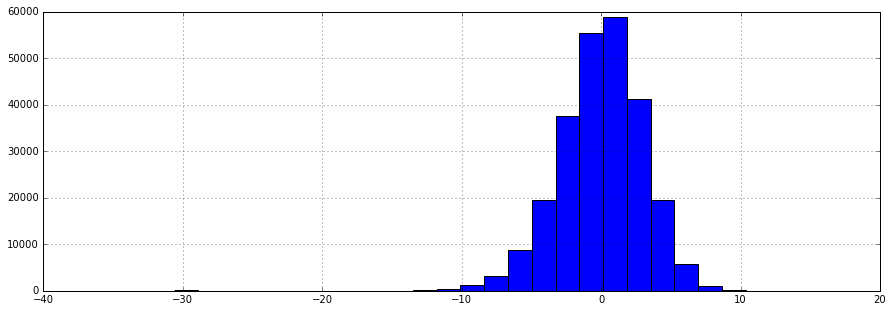

In [40]:
## histogram for fun
round_data.Strokes_Gained.hist(bins=25,figsize=(15,5));

In [41]:
## first 3 rows of dataframe
round_data.head(3)

,Tournament_Year,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Event_Name,Course_Name,Tee_Time,Round_Score,End_of_Round_Finish_Pos._(text),Hole_Started_On,Field_Ave,Strokes_Gained
0,2003,16,656,1320,"Estes, Bob",1,Mercedes Championships,Plantation Course at Kapalua,11:50,66,T6,1.0,69.361111,3.361111
1,2003,16,656,1361,"Forsman, Dan",1,Mercedes Championships,Plantation Course at Kapalua,11:00,69,T14,1.0,69.361111,0.361111
2,2003,16,656,1761,"Mattiace, Len",1,Mercedes Championships,Plantation Course at Kapalua,13:00,75,36,1.0,69.361111,-5.638889


Now for our 'Model'. Again for simplicity, I will just use a exponentially weighted moving average for the expected Strokes Gained to the Field of the golfer. This has the benefit of being an intuitively appealing method and being easy to do in pandas. The data is actually already in chronological order which is convenient. I'll fit a half-life parameter to the data by choosing the parameter for which the prediction (the exponentially weighted moving average of past strokes gained results) is most correlated with the outcome (strokes gained for the round). I won't worry about over-fitting the training data since it's just one parameter.

In [42]:
## recording correlation with future results of ewma precition
results = []
for halflife in np.linspace(2,80,40):
    df = round_data[['Player_Number','Strokes_Gained']].copy()
    df['prediction'] = df.groupby('Player_Number')['Strokes_Gained']\
                         .transform(lambda x: 
                                    x.shift(1)\
                                    .ewm(halflife=halflife).mean())
    df = df.dropna()
    results.append(np.corrcoef(df.Strokes_Gained,df.prediction)[0,1])

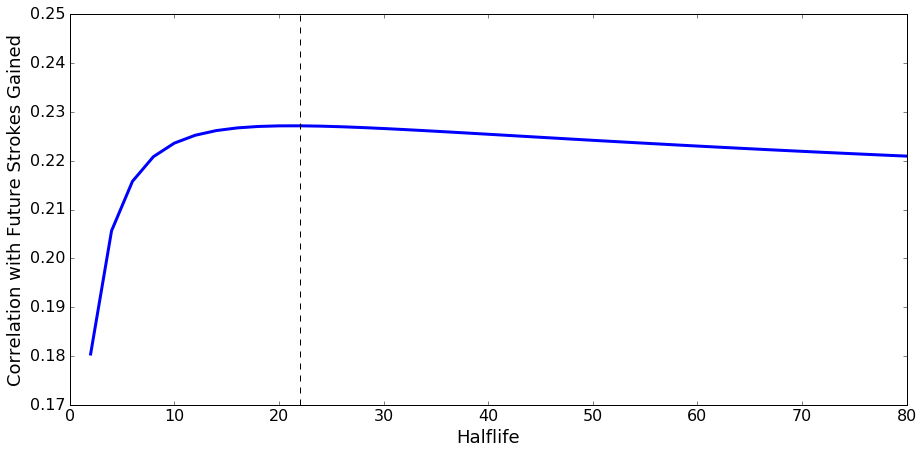

In [43]:
## plotting halflife vs. correlation
fig,ax = plt.subplots(1,1,figsize=(15,7))
plt.plot(np.linspace(2,80,40),results,lw=3);
plt.ylim(0.17,0.25);
plt.axvline(np.linspace(2,80,40)[np.argmax(results)],
            c='black',ls='--');
plt.xlabel('Halflife',fontsize=18);
plt.ylabel('Correlation with Future Strokes Gained',fontsize=18);
ax.tick_params(labelsize=16);

Now I'll insert this "model"'s prediction into the dataframe for the expected Strokes Gained of the Player. I'll also insert the different between his Strokes Gained performance for the day and what was expected of him. This will give us a more useful result variable.

In [44]:
## inserting Expected Result and difference bettwen expected and true
halflife = np.linspace(2,80,40)[np.argmax(results)]
round_data['Exp_StrokesGained'] = round_data.groupby('Player_Number')\
                                  ['Strokes_Gained']\
                                  .transform(lambda x: x.shift(1)\
                                      .ewm(halflife=halflife).mean())

## first round for each player is null because no data 
## so filling with 0 which is saying he is expected to tie field
round_data.Exp_StrokesGained.fillna(0,inplace=True)
round_data['Net_Result'] = round_data['Strokes_Gained'] - round_data['Exp_StrokesGained']

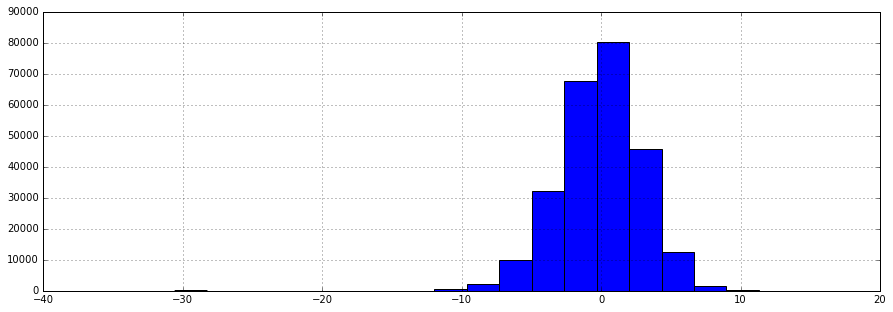

In [45]:
## histogram of net result variable
round_data.Net_Result.hist(bins=20,figsize=(15,5));

In [46]:
## standard deviation before prediction and residuals
## shows the prediction is somewhat useful in explaining
## some variation
round_data.Strokes_Gained.std(),round_data.Net_Result.std()

(2.960602760298323, 2.9025255648037853)

Now we are all ready to do some statistical tests. We have a result variable and have made it so that our samples are independent by controlling for the overall skill of each player. We can try one-way ANOVA first. Let's make a nested list that we'll feed to the scipy ANOVA function.

In [47]:
## making a list of arrays for anova function
nested_list = []
for tup,df in round_data.groupby(['Tournament_Year',
                                  'Permanent_Tournament_#',
                                  'Course_#','Round_Number',
                                  'Tee_Time','Hole_Started_On']):
    nested_list.append(df.Net_Result.values)

In [48]:
## first sample
nested_list[0]

array([-0.71188839,  2.33474434,  1.67479521])

In [49]:
## making sure we have groups of 2 or 3 only
all(len(list_)==2 or len(list_)==3 for list_ in nested_list)

True

In [50]:
## import and feed scipy anova function
from scipy.stats import f_oneway

f_stat,p_value = f_oneway(*nested_list)

In [51]:
## look at results
f_stat,p_value

(1.0691939363966874, 2.6323346983777417e-31)

So these are very strong results. I am cautious however since I am not sure that all of the three assumptions that are necessary for this test to be valid are true. I am confident about the independence assumption, and decently confident about the homoskedasticity assumption, but less confident about the normality assumption. 

As an alternative test we can do the Kruskal-Wallis H-test. This test is for the null hypothesis that the medians of the samples are the same. It is a non-parametric version of ANOVA and only assumes that the samples are independent of one another (which I believe is true). Let's see the results of this test.. 

In [52]:
## import and feed scipy kruskal-wallis function
from scipy.stats import kruskal

stat,p_value = kruskal(*nested_list)

In [53]:
## look at results
stat,p_value

(100464.64203812063, 6.3418111409966217e-22)

Another strong result! This is very interesting but still the result is not very tangible. To investigate the magnitude of the effect and visualize how robust it is, let's do a permutation test. First let's define some closeness-within-a-group metric. I will use the average distance between each of the possible pairs of players within a group (1 pair if it is a twosome and 3 pairs if it is a threesome) as this metric and take the average across all groups as the metric that tells me how close the groups are on average. First let's compute this metric for the real, unpermuted, data.

In [54]:
## import pdist to compute pairwise distances
from scipy.spatial.distance import pdist

In [55]:
## compute metric for real data
metric_unpermuted = np.mean([np.mean(pdist(sample[:,None]))
                             for sample in nested_list])

In [56]:
## view the metric
metric_unpermuted

3.1849814247566357

Now we will randomly permute the values of the *Net_Result* variable many times and then compute the value of the metric of interest each time. This will enable us to see how likely our result would have happened if the groups were done completely randomly. We will also be able to visualize the metric computed on the real data in the context of random configurations of the groups.

Since all that matters is the number of twosomes and the number of threesomes for defining the groups after the permutation, I can avoid doing this explicitly with the same groupby. I will do it by extracting the values from the dataframe and using some handy numpy functions.

In [57]:
## define metric function
def compute_metric(samples):
    return np.mean([np.mean(pdist(sample[:,None]))
                    for sample in samples])

In [58]:
## extract values and number of twosomes and number of threesomes
result_values = round_data.Net_Result.values
counts = round_data.groupby(['Tournament_Year',
                             'Permanent_Tournament_#',
                             'Course_#','Round_Number',
                             'Tee_Time','Hole_Started_On']).size()\
                    .reset_index().rename(columns={0:'Num_Groups'})\
                    .Num_Groups.value_counts()
num_twos,num_threes = counts[2],counts[3]

In [59]:
## view results
num_twos,num_threes

(35872, 60343)

In [60]:
## indicies to split array at (no need for last index)
indicies = np.cumsum(np.concatenate([[2]*num_twos,
                                     [3]*num_threes]))[:-1]

In [61]:
## permute 10,000 times and compute metric each time
metrics_permuted = []
for i in xrange(10000):
    result_values = np.random.permutation(result_values)
    samples = np.split(result_values,indicies)
    metrics_permuted.append(compute_metric(samples))

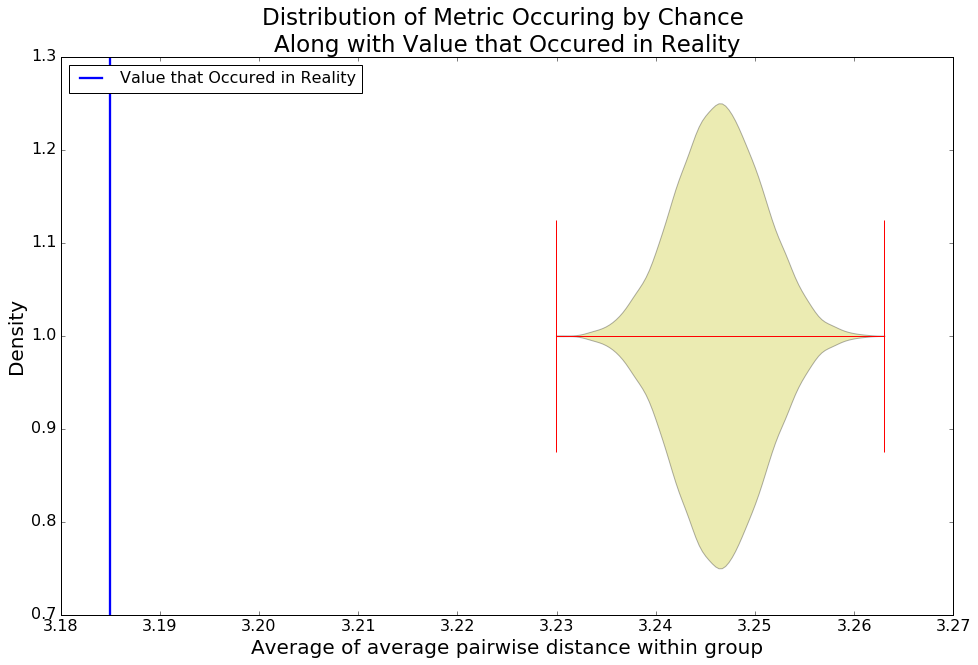

In [62]:
## make fancy plot of results
fig,ax = plt.subplots(1,1,figsize=(16,10))
plt.violinplot(metrics_permuted,vert=False);
plt.axvline(metric_unpermuted,lw=2.3,
            label='Value that Occured in Reality');
plt.xlabel('Average of average pairwise distance within group',
           fontsize=20);
plt.ylabel('Density',fontsize=20);
plt.title('''Distribution of Metric Occuring by Chance 
Along with Value that Occured in Reality''',fontsize=23);
ax.tick_params(labelsize=16);
plt.legend(loc=2,prop={'size':16});

So the above plot shows that even the most extreme value on the low end of the spectrum of the metric that occurred by chance is about 5 standard deviations from the value that occurred from the groups in reality. This is another strong result.

### Conclusion

The permutation test along with the statistical tests allows me to confidently conclude that PGA Tour players display a feed-off effect where players playing in the same group perform more similarly to each other that one would expect to see according to random chance. Although the size of the effect is only about 0.06 strokes different from what one would expect by chance, measured in terms of the average pairwise distance between all possible pairs within a group, the effect is astronomically unlikely to be attributable to chance.

I will end this post here and wait to explore questions such as the ones mentioned at the beginning for part two.

I will leave it to the reader to discern the psychological mechanisms behind this effect. In my mind there is a moral behind this analysis - even from a purely competitive perspective, you should try to establish a good rapport with your playing partners because what's good for them is going to be good for you as the scores of group-members are tied together in a statistically significant way.